The purpose of this notebook is to take the diamond data generated by diamond_scrape.ipynb and make a predictive linear regression model that uses the GIA rating data to predict the price of a diamond.

In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()#make pretty 

import scipy.stats as stats

import itertools

import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

# Step 1
- Make a dataframe of the data.


In [188]:
def add_diamonds(dataframe,data_rows,column_names):
    #given an empty dataframe, and a list of lists containing the diamond data,
    #returns updated datafram
    for x,row in enumerate(data_rows):
        diamond_dict = {key:[] for key in column_names}
        for i,key in enumerate(diamond_dict.keys()):
            diamond_dict[key] = row[i]
        dataframe.iloc[x] = diamond_dict
    
    return dataframe

In [189]:
all_diamonds = []
for i in range(1,16):#There were 16 different pkl files that will be combined, you can change the range accordingly if you have more/fewer.
    with open('diamond_list'+str(i)+'.pkl','rb') as picklefile:
        diamond_list = pickle.load(picklefile)
    all_diamonds.extend(diamond_list)
    

In [190]:
column_names = ['Shape','Color','Cut','Clarity','Carat','Cert','Price','Fluor','Seller']
df = pd.DataFrame(columns=column_names,index=range(len(all_diamonds)))
df = add_diamonds(df,all_diamonds,column_names)
#drop duplicates
df.drop_duplicates(keep='first',inplace=True)
df.head()

,Shape,Color,Cut,Clarity,Carat,Cert,Price,Fluor,Seller
0,round,I,EX,VVS1,0.5,GIA,"$1,400",no,Yadav
1,round,D,EX,SI1,0.51,GIA,"$1,400",me,Yadav
2,round,G,EX,VVS1,0.5,GIA,"$1,400",fa,Adiamor
3,round,E,VG,SI1,0.52,GIA,"$1,400",no,Adiamor
4,round,H,EX,SI1,0.51,GIA,"$1,400",no,Adiamor


Lets save the dataframe because loading and converting is not something we want to do more than once. 

In [192]:
with open('diamond_df.pkl','wb') as picklefile:
    pickle.dump(df,picklefile)

In [193]:
with open('diamond_df.pkl','rb') as picklefile:
    df = pickle.load(picklefile)

# Step 2
- fix numerical fields to proper format
- one-hot the categorical features

In [164]:
def format_df(df,numerize):
    formatted_df = df.copy()
    
    #fix the prices
    
    price_list = []
    for price in df.Price:
        p = price[1:] 
        p = int(''.join(p.split(',')))
        price_list.append(p)
    formatted_df['Price'] = price_list
    
    #drop the cert
    formatted_df.drop('Cert',axis=1,inplace=True)
    
    if numerize:
    #numerical conversion of color code to AGS numerical code
        abc = list(map(chr, range(ord('D'), ord('X')+1)))
        color_nums = [i*0.5 for i in range(21)]
        colornums = []
        for i,color in enumerate(formatted_df.Color):
            for letter,number in zip(abc,color_nums):
                if color == letter:
                    colornums.append(number)  
        formatted_df.insert(2,'ColorNum',colornums,True)
        # numerical conversion of clarity code to AGS numerical code
        clarity_names = df.Clarity.unique()
        cl = sorted(clarity_names)
        cl_nums = [0,0,5,3,4,1,2]
        clarnums = []
        for i,clarity in enumerate(df.Clarity):
            for word,number in zip(cl,cl_nums):
                if clarity == word:
                    clarnums.append(number)  
        formatted_df.insert(5,'ClarityNum',clarnums,True)
    
    #fix the carat string -> carat int
    carats = formatted_df.Carat
    icarats = [float(i) for i in carats]
    formatted_df.Carat = icarats
    formatted_df.sort_values(by='Price',inplace=True)
    return formatted_df

In [175]:
df_num = format_df(df,numerize=1)
df_non_num = format_df(df,numerize=0)
    
df_num.head()

,Shape,Color,ColorNum,Cut,Clarity,ClarityNum,Carat,Price,Fluor,Seller
30032,round,F,1.0,VG,SI1,5,0.22,340,no,Adiamor
51046,round,E,0.5,EX,SI1,5,0.18,340,st,Adiamor
52054,round,F,1.0,GO,VS2,4,0.18,340,st,Adiamor
53003,marquise,K,3.5,EX,VS1,3,0.38,340,fa,Adiamor
54982,round,E,0.5,VG,VS1,3,0.18,340,fa,Adiamor


- Set extra column for numerical values for Color scale. This numerical value is given by AGS, The American Gem Society
- Similar for clarity values

# VERY IMPORTANT REMEMBER to ONE-HOT Color and Clarity for comparison to  other  model

In [173]:
df_merged1 = pd.concat([df_num, pd.get_dummies(df[['Cut','Seller','Shape','Fluor']], drop_first=False)], axis=1)
df_nosell_num = pd.concat([df_num, pd.get_dummies(df[['Cut','Shape','Fluor']], drop_first=False)], axis=1)
df_merged1.head()

df_merged2 = pd.concat([df_non_num,pd.get_dummies(df[['Cut','Seller','Shape','Fluor','Clarity','Color']]
                        ,drop_first=False)],axis=1)
df_nosell_non_numC = pd.concat([df_non_num,pd.get_dummies(df[['Cut','Shape','Fluor','Clarity','Color']]
                        ,drop_first=False)],axis=1)

In [167]:
#df_nosell_non_numC = df_nosell_non_numC.drop( df.columns[[0,1,2,3,7,8]],axis=1)
df_nosell_non_numC.head()
df_nosell_non_numC.columns

Index(['Shape', 'Color', 'Cut', 'Clarity', 'Carat', 'Price', 'Fluor', 'Seller',
       'Cut_EX', 'Cut_GO', 'Cut_VG', 'Shape_asscher', 'Shape_cushion',
       'Shape_emerald', 'Shape_heart', 'Shape_marquise', 'Shape_oval',
       'Shape_pear', 'Shape_princess', 'Shape_radiant', 'Shape_round',
       'Fluor_fa', 'Fluor_me', 'Fluor_no', 'Fluor_st', 'Fluor_ve',
       'Clarity_FL', 'Clarity_IF', 'Clarity_SI1', 'Clarity_VS1', 'Clarity_VS2',
       'Clarity_VVS1', 'Clarity_VVS2', 'Color_D', 'Color_E', 'Color_F',
       'Color_G', 'Color_H', 'Color_I', 'Color_J', 'Color_K'],
      dtype='object')

In [179]:


df_numeric =  df_num.drop( df.columns[[0,1,3,4,7,8]],axis=1)
df_onehot = df_merged1.drop(df.columns[[0,1,3,4,7,8]],axis=1)
df_small = df_onehot.iloc[:10000,:].reset_index(drop=True)
df_small.head()

,ColorNum,Cut,ClarityNum,Price,Cut_EX,Cut_GO,Cut_VG,Seller_Adiamor,Seller_Do,Seller_With,...,Shape_oval,Shape_pear,Shape_princess,Shape_radiant,Shape_round,Fluor_fa,Fluor_me,Fluor_no,Fluor_st,Fluor_ve
0,2.5,EX,1,1400,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0.0,EX,5,1400,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1.5,EX,1,1400,1,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0.5,VG,5,1400,0,0,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,2.0,EX,5,1400,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [169]:
df_numeric.describe()
df_onehot.head()

,ColorNum,ClarityNum,Carat,Price,Cut_EX,Cut_GO,Cut_VG,Seller_Adiamor,Seller_Do,Seller_With,...,Shape_oval,Shape_pear,Shape_princess,Shape_radiant,Shape_round,Fluor_fa,Fluor_me,Fluor_no,Fluor_st,Fluor_ve
0,2.5,1,0.50,1400,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0.0,5,0.51,1400,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,1.5,1,0.50,1400,1,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0.5,5,0.52,1400,0,0,1,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,2.0,5,0.51,1400,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [181]:
df_num.columns

Index(['Shape', 'Color', 'ColorNum', 'Cut', 'Clarity', 'ClarityNum', 'Carat',
       'Price', 'Fluor', 'Seller'],
      dtype='object')

In [17]:
df_onehot.columns

Index(['ColorNum', 'ClarityNum', 'Carat', 'Price', 'Cut_EX', 'Cut_GO',
       'Cut_VG', 'Seller_Adiamor', 'Seller_Do', 'Seller_With', 'Seller_Yadav',
       'Shape_asscher', 'Shape_cushion', 'Shape_emerald', 'Shape_heart',
       'Shape_marquise', 'Shape_oval', 'Shape_pear', 'Shape_princess',
       'Shape_radiant', 'Shape_round', 'Fluor_fa', 'Fluor_me', 'Fluor_no',
       'Fluor_st', 'Fluor_ve'],
      dtype='object')

# Step 3
- train-test-split
- ridge
- polynomial features

- Note: there are several functions that essentially perform the same task but with slight variations. They are all used below and the most accurate model is given in the next fold. 

In [206]:
def test_train_split(dfX,dfy,testsize):
    #takes a dataframe subset of X: dfX and y: dfy and does a test,train,split based on the percentage passed,
    #returns nothing (possibly something to iterate on), prints stats about model, coeffs, R2, etc.
    X_train, X_test, y_train, y_test = train_test_split(dfX,
                                                        dfy,
                                                        test_size=testsize, random_state=100)
    
    m = LinearRegression()
    m.fit(X_train,y_train)
    #print('Training R2 = {}, Testing R2 = {}'.format(m.score(X_train,y_train),m.score(X_test,y_test)))
    #print('Intercept: ',m.intercept_)
    #for name,coeff in zip(dfX.columns,m.coef_):
     #   print(name,coeff)
        

In [91]:
def test_train_split_poly(dfX,dfy,testsize,degree_,verbose,scaled):
    #same as above but you also specify the degree of the polynomial expansion of features
    X_train, X_test, y_train, y_test = train_test_split(dfX,
                                                        dfy,
                                                        test_size=testsize, random_state=100)
    
    std = StandardScaler()
    std.fit(X_train.values)
    ## This step applies the scaler to the train set.
    ## It subtracts the mean it learned in the previous step and then divides by the standard deviation
    X_tr = std.transform(X_train.values)
    ##apply same scaler that from training set to the test set
    X_te = std.transform(X_test.values)
    
    if scaled:
        m = LinearRegression()
        p = PolynomialFeatures(degree=degree_)
        m.fit(p.fit_transform(X_tr),y_train)
        train_score = m.score(p.transform(X_tr),y_train)
        test_score = m.score(p.transform(X_te),y_test)
        print('Poly Training R2 = {},Poly Testing R2 = {}'.format(train_score,test_score))
        
        
    else:    
        m = LinearRegression()
        p = PolynomialFeatures(degree=degree_)
        m.fit(p.fit_transform(X_train),y_train)
        train_score = m.score(p.transform(X_train),y_train)
        test_score = m.score(p.transform(X_test),y_test)
        print('Poly Training R2 = {},Poly Testing R2 = {}'.format(train_score,test_score))

    
    if verbose:
        #print("Params: ", p.get_params())
        #names = dfX.columns
        ##   full_sum(p.transform(X_tr),y_train)
        #else:
        #    full_sum(p.transform(X_train),y_train)
        
        
        if degree_ ==2:
            name_list = [i for i in names]+[i for i in itertools.product(names,names)]
            name_list = [1]+name_list
            for name,coeff in zip(name_list,m.coef_):
                print(name,coeff)
        else:
            for name,coeff in zip(p.get_feature_names(),m.coef_):
                print(name,coeff)
    

In [53]:
def Lasso_CV(dfX,dfy,testsize,alphavec):
    #lasso 
    X_train, X_test, y_train, y_test = train_test_split(dfX,
                                                        dfy,
                                                        test_size=testsize, random_state=100)
    
    std = StandardScaler()
    std.fit(X_train.values)
    ## This step applies the scaler to the train set.
    ## It subtracts the mean it learned in the previous step and then divides by the standard deviation
    X_tr = std.transform(X_train.values)
    ##apply same scaler that from training set to the test set
    X_te = std.transform(X_test.values)
    
    #train model and find optimal alpha for regularization
    lasso_model = LassoCV(alphas = alphavec, cv=10)
    lasso_model.fit(X_tr, y_train)
    #test model on scaled test set, Y_bar is the predicted y(prices) from the test set
    Y_bar = lasso_model.predict(X_te)
    print('Ideal alpha for L1 penalty: ',lasso_model.alpha_)
    print('R2 : ',r2_score(y_test, Y_bar) )
    print('MAE : ',mae(y_test,Y_bar))
    for name,coeff in zip(X_train.columns, lasso_model.coef_):
        print(name,coeff)
    

In [1]:
def Lasso_CV_poly(dfX,dfy,testsize,alphavec,degree_,verbose):
    
    X_train, X_test, y_train, y_test = train_test_split(dfX,
                                                        dfy,
                                                        test_size=testsize, random_state=100)
    std = StandardScaler()
    std.fit(X_train.values)
    ## This step applies the scaler to the train set.
    ## It subtracts the mean it learned in the previous step and then divides by the standard deviation
    X_tr = std.transform(X_train.values)
    ##apply same scaler that from training set to the test set
    X_te = std.transform(X_test.values)
    print(X_te.shape,X_test.shape)
    
    m = LinearRegression()
    p = PolynomialFeatures(degree=degree_)
    
    print(p.fit_transform(X_tr).shape)
    
    #train model and find optimal alpha for regularization
    lasso_model = LassoCV(alphas = alphavec, cv=10)
    lasso_model.fit(p.fit_transform(X_tr),y_train)
    #test model on scaled test set, Y_bar is the predicted y(prices) from the test set
    Y_bar = lasso_model.predict(p.fit_transform(X_te))
    print('Ideal alpha for L1 penalty: ',lasso_model.alpha_)
    print('Train R2: ',r2_score(p.fit_transform(X_tr),y_train))
    print('test R2 : ',r2_score(y_test, Y_bar) )
    print('MAE : ',mae(y_test,Y_bar))
    #change for larger print statements
    #full_sum(p.fit_transform(X_tr),y_train,lasso_model.alpha_)
    diag_plot(y_test,Y_bar)
    

In [83]:
def Lars_path(dfX,dfy,testsize):
    
    X_train, X_test, y_train, y_test = train_test_split(dfX,
                                                        dfy,
                                                        test_size=testsize, random_state=100)
    std = StandardScaler()
    std.fit(X_train.values)
    X_tr = std.transform(X_train.values)
    
    
    print("Computing regularization path using the LARS ...")
    alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')
    # plotting the LARS path

    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]

    plt.figure(figsize=(10,10))
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim()
    plt.vlines(xx, ymin, ymax, linestyle='dashed')
    plt.xlabel('|coef| / max|coef|')
    plt.ylabel('Coefficients')
    plt.title('LASSO Path')
    plt.axis('tight')
    plt.legend(X_train.columns)
    plt.show()
    

In [125]:
def full_sum(X,y,alpha_):
    
    if alpha_:#lasso
        model= sm.OLS(y,X)
        results = model.fit_regularized(alpha=alpha_)
        print(results.summary())
    else:    
        model = sm.OLS(y,X)
        results = model.fit()
        print(results.summary())
        print('R2:     ',results.rsquared)
        print('R2 Adj: ',results.rsquared_adj)

In [208]:
def diag_plot(y,pred):
    res = y - pred
    plot = plt.subplot(1,1,1)
    stats.probplot(res, dist="norm", plot=plt)
    plt.title('Normal Q-Q plot')
    fig = plot.get_figure()
    fig.savefig('Q-Q.png') 

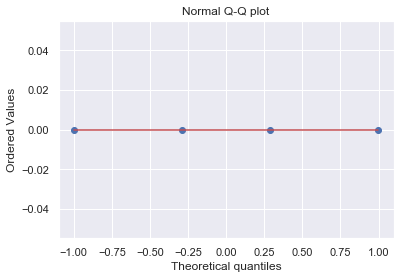

In [128]:
y = np.array([0,1,10,3])
pred = np.array([0,1,10,3])

diag_plot(y,pred)

In [52]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

In [82]:
df_numeric_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
index         1000 non-null int64
ColorNum      1000 non-null float64
ClarityNum    1000 non-null int64
Carat         1000 non-null object
Price         1000 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 39.2+ KB


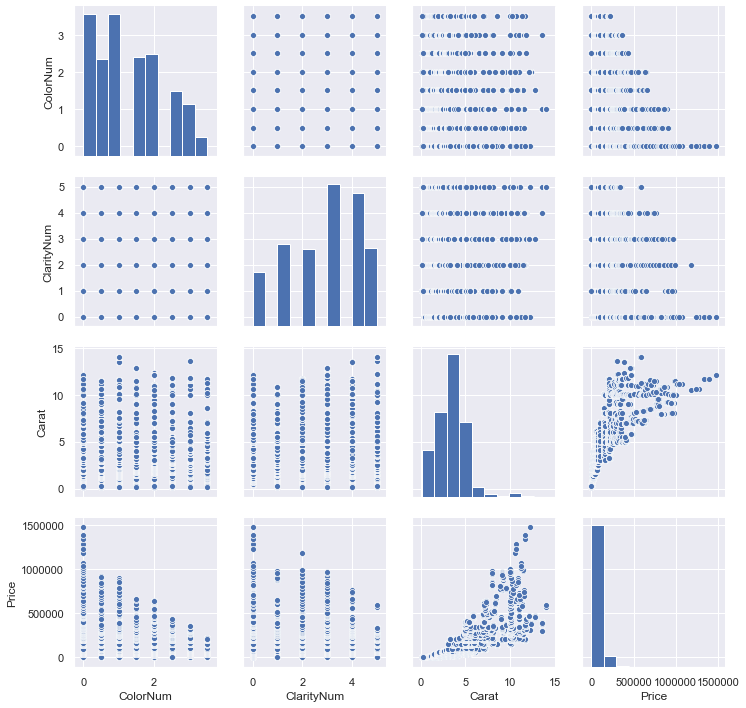

In [96]:
sns.pairplot(df_numeric)

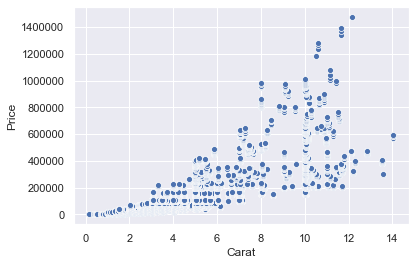

In [197]:
plot1 = sns.scatterplot(df_num.Carat,df_num.Price,alpha=1)
fig1 = plot1.get_figure()
fig1.savefig('Carat.png') 

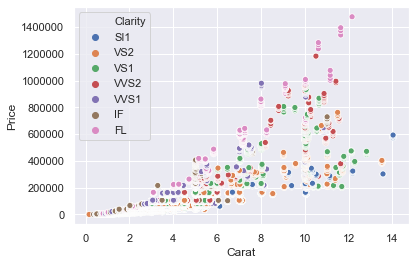

In [196]:
plot = sns.scatterplot(df_num.Carat,df_num.Price,alpha=1,hue=df_num.Clarity)
fig = plot.get_figure()
fig.savefig('Clarity.png') 

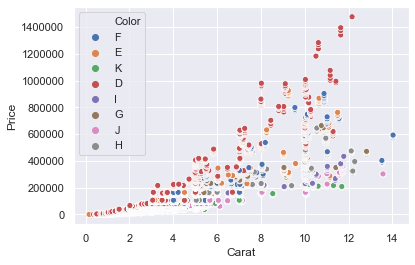

In [195]:
plot2 = sns.scatterplot(df_num.Carat,df_num.Price,alpha=1,hue=df_num.Color)
fig2 = plot2.get_figure()
fig2.savefig('Color.png')

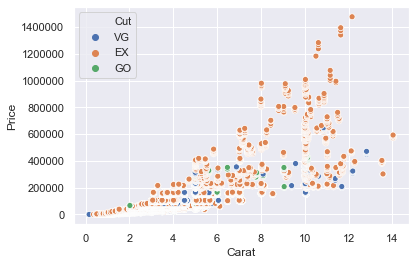

In [194]:
plot3 = sns.scatterplot(df_num.Carat,df_num.Price,alpha=1,hue=df_num.Cut)
fig3 = plot3.get_figure()
fig3.savefig('Cut.png')

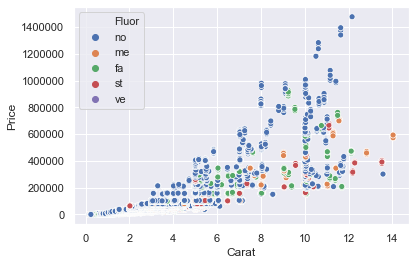

In [155]:
plot4 = sns.scatterplot(df_num.Carat,df_num.Price,alpha=1,hue=df_num.Fluor)
fig4 = plot4.get_figure()
fig4.savefig('fluor.svg')

In [15]:
#first test only numeric values, no cut info
test_train_split(df_numeric[['ColorNum','ClarityNum','Carat']],df_numeric.Price,0.20)

Training R2 = 0.6659411081912321, Testing R2 = 0.6743723407291471
Intercept:  -7057.211238715536
ColorNum -20869.547010408136
ClarityNum -7459.095010127232
Carat 36959.22919885194


In [94]:
#now with polynomials too
test_train_split_poly(df_numeric[['ColorNum','ClarityNum','Carat']],df_numeric.Price,0.20,degree_=2,verbose=1,scaled=1)

Poly Training R2 = 0.8709492834572017,Poly Testing R2 = 0.8700014014704816
Params:  {'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                 4.095e+04
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:24:34   Log-Likelihood:            -6.3700e+05
No. Observations:               54623   AIC:                         1.274e+06
Df Residuals:                   54613   BIC:                         1.274e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

In [62]:
#same but with one hot    'Seller_Adiamor', 'Seller_Do', 'Seller_With', 'Seller_Yadav', removed seller info
namelist = ['ColorNum', 'ClarityNum', 'Carat', 'Cut_EX', 'Cut_GO',
       'Cut_VG', 
       'Shape_asscher', 'Shape_cushion', 'Shape_emerald', 'Shape_heart',
       'Shape_marquise', 'Shape_oval', 'Shape_pear', 'Shape_princess',
       'Shape_radiant', 'Shape_round', 'Fluor_fa', 'Fluor_me', 'Fluor_no',
       'Fluor_st', 'Fluor_ve']
test_train_split(df_onehot[namelist],df_onehot.Price,0.20)

Training R2 = 0.6925048714961706, Testing R2 = 0.6998991559273213
Intercept:  -1.4411518395025228e+16
ColorNum -20827.115295944437
ClarityNum -7028.7713516715985
Carat 38195.238506472335
Cut_EX -3.757611213251503e+16
Cut_GO -3.757611213251264e+16
Cut_VG -3.757611213251421e+16
Shape_asscher 5.2524451817206344e+16
Shape_cushion 5.252445181720192e+16
Shape_emerald 5.252445181721048e+16
Shape_heart 5.252445181721675e+16
Shape_marquise 5.252445181723344e+16
Shape_oval 5.252445181721036e+16
Shape_pear 5.252445181722367e+16
Shape_princess 5.252445181720692e+16
Shape_radiant 5.252445181721028e+16
Shape_round 5.2524451817229784e+16
Fluor_fa -536821289694929.25
Fluor_me -536821289706647.94
Fluor_no -536821289690884.2
Fluor_st -536821289719253.44
Fluor_ve -536821289735051.0


In [69]:
test_train_split_poly(df_onehot[namelist],df_onehot.Price,0.20,degree_=2,verbose=1,scalar=0)

Poly Training R2 = 0.9242374291702303,Poly Testing R2 = 0.9224834569205196
Params:  {'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}
1 98312447364.9089
ColorNum -21064.335237791052
ClarityNum -11568.456565885857
Carat 63653.521406789325
Cut_EX 1393768901305116.0
Cut_GO 2768337246236900.0
Cut_VG 645881826114008.5
Shape_asscher -867532289676162.9
Shape_cushion 117043973178015.36
Shape_emerald 413090830511446.4
Shape_heart -148702420203293.16
Shape_marquise 324166930225092.56
Shape_oval -181677383711660.8
Shape_pear -160853633487423.12
Shape_princess -523492135654997.5
Shape_radiant -352702389145164.8
Shape_round 134164944549079.1
Fluor_fa 120603122794161.67
Fluor_me 1971260534015583.0
Fluor_no -233072402275779.9
Fluor_st 146542918218.95312
Fluor_ve 100437501338203.44
('ColorNum', 'ColorNum') -648.240234375
('ColorNum', 'ClarityNum') 7946.125
('ColorNum', 'Carat') -22674.09375
('ColorNum', 'Cut_EX') 204424755394707.9
('ColorNum', 'Cut_GO') 90339024127288.83
('C

In [96]:
namelist = ['ColorNum', 'ClarityNum', 'Carat', 'Cut_EX', 'Cut_GO',
       'Cut_VG', 
       'Shape_asscher', 'Shape_cushion', 'Shape_emerald', 'Shape_heart',
       'Shape_marquise', 'Shape_oval', 'Shape_pear', 'Shape_princess',
       'Shape_radiant', 'Shape_round', 'Fluor_fa', 'Fluor_me', 'Fluor_no',
       'Fluor_st', 'Fluor_ve']
test_train_split_poly(df_onehot[namelist],df_onehot.Price,0.20,degree_=2,verbose=1,scaled=1)

Poly Training R2 = 0.9242374291702303,Poly Testing R2 = 0.9224834569205196
Params:  {'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     5194.
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:26:13   Log-Likelihood:            -6.2245e+05
No. Observations:               54623   AIC:                         1.245e+06
Df Residuals:                   54494   BIC:                         1.246e+06
Df Model:                         128                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

In [102]:
namelist = ['Carat', 'Cut_EX', 'Cut_GO', 'Cut_VG', 'Shape_asscher',
       'Shape_cushion', 'Shape_emerald', 'Shape_heart', 'Shape_marquise',
       'Shape_oval', 'Shape_pear', 'Shape_princess', 'Shape_radiant',
       'Shape_round', 'Fluor_fa', 'Fluor_me', 'Fluor_no', 'Fluor_st',
       'Fluor_ve', 'Clarity_FL', 'Clarity_IF', 'Clarity_SI1', 'Clarity_VS1',
       'Clarity_VS2', 'Clarity_VVS1', 'Clarity_VVS2', 'Color_D', 'Color_E',
       'Color_F', 'Color_G', 'Color_H', 'Color_I', 'Color_J', 'Color_K']
test_train_split_poly(df_nosell_non_numC[namelist],df_nosell_non_numC.Price,0.20,degree_=2,verbose=1,scaled=1)

Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Params:  {'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     2546.
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:38:06   Log-Likelihood:            -6.1509e+05
No. Observations:               54623   AIC:                         1.231e+06
Df Residuals:                   54275   BIC:                         1.234e+06
Df Model:                         347                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

('Shape_radiant', 'Color_F') 30472516561720.367
('Shape_radiant', 'Color_G') -33982027913788.453
('Shape_radiant', 'Color_H') -57225760718277.586
('Shape_radiant', 'Color_I') -61948345826783.766
('Shape_radiant', 'Color_J') 30518603382200.344
('Shape_radiant', 'Color_K') 35554796755392.91
('Shape_round', 'Carat') 26642226144910.062
('Shape_round', 'Cut_EX') 18455006527312.305
('Shape_round', 'Cut_GO') -15778094782814.277
('Shape_round', 'Cut_VG') -7824706229085.96
('Shape_round', 'Shape_asscher') -27896225981803.22
('Shape_round', 'Shape_cushion') -28521425243489.656
('Shape_round', 'Shape_emerald') 48169133060638.2
('Shape_round', 'Shape_heart') 18852012505679.484
('Shape_round', 'Shape_marquise') -18740023415651.816
('Shape_round', 'Shape_oval') -44352512035598.11
('Shape_round', 'Shape_pear') 25458482668399.883
('Shape_round', 'Shape_princess') 30901107047041.484
('Shape_round', 'Shape_radiant') -4216451551092.8105
('Shape_round', 'Shape_round') -15969046140245.902
('Shape_round', '

In [58]:
#pick the alphas the model will choose between, and iterate for best value
alphavec = 10**np.linspace(-2,2,200)
Lasso_CV(df_onehot[namelist],df_onehot.Price,0.20,alphavec)

Ideal alpha for L1 penalty:  6.222570836730231
R2 :  0.7032993501087315
MAE :  21974.771834927426
ColorNum -20687.13309468709
ClarityNum -10998.975170065569
Carat 66233.86795837448
Cut_EX -639.170928196552
Cut_GO 284.36999517208864
Cut_VG 0.0
Seller_Adiamor 4081.5222197893127
Seller_Do 136.35165420019652
Seller_With -1048.9817280860607
Seller_Yadav -0.0
Shape_asscher -1123.0437200173462
Shape_cushion -2971.6839257962724
Shape_emerald -1198.3948862504126
Shape_heart 93.59690900274676
Shape_marquise 1781.5222714429806
Shape_oval -880.2210752132031
Shape_pear 2077.0222221495933
Shape_princess -1613.1897975593265
Shape_radiant -737.0721914757487
Shape_round 8039.989210639364
Fluor_fa 0.0
Fluor_me -3543.8939211729844
Fluor_no 2164.062816859196
Fluor_st -5789.565861710716
Fluor_ve -2360.0464460732965


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1344151285890.7812, tolerance: 33369432096.597946
  positive)


Computing regularization path using the LARS ...


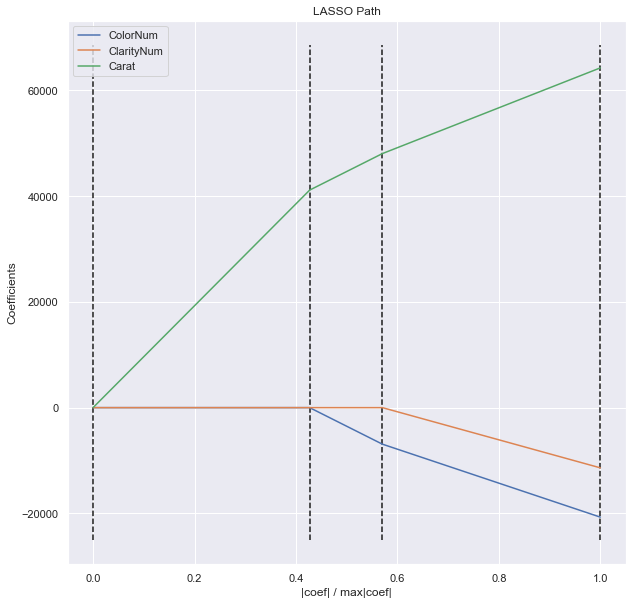

In [87]:

Lars_path(df_numeric[['ColorNum','ClarityNum','Carat']],df_numeric.Price,0.20)

In [81]:
alphavec = 10**np.linspace(-2,2,200)
Lasso_CV_poly(df_onehot[namelist],df_onehot.Price,0.20,alphavec,2,1)

(13656, 21) (13656, 21)
(54623, 253)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 290099483675.1289, tolerance: 33369432096.597946
  positive)


Ideal alpha for L1 penalty:  15.702901247293775
R2 :  0.9224792421956653
MAE :  12433.646045064648


# THE BELOW GENERATES THE TOP MODEL OF ALL EXPERIMENTS

The model takes a polynomial combination of the the Cut, Clarity, Carat, Color, shape and fluorescence. L1 and L2 norms were not found to change the results and therefore the optimal solution lies within has meaningful contributions from all features. 

In [103]:
namelist = ['Carat', 'Cut_EX', 'Cut_GO', 'Cut_VG', 'Shape_asscher',
       'Shape_cushion', 'Shape_emerald', 'Shape_heart', 'Shape_marquise',
       'Shape_oval', 'Shape_pear', 'Shape_princess', 'Shape_radiant',
       'Shape_round', 'Fluor_fa', 'Fluor_me', 'Fluor_no', 'Fluor_st',
       'Fluor_ve', 'Clarity_FL', 'Clarity_IF', 'Clarity_SI1', 'Clarity_VS1',
       'Clarity_VS2', 'Clarity_VVS1', 'Clarity_VVS2', 'Color_D', 'Color_E',
       'Color_F', 'Color_G', 'Color_H', 'Color_I', 'Color_J', 'Color_K']
test_train_split_poly(df_nosell_non_numC[namelist],df_nosell_non_numC.Price,0.20,degree_=2,verbose=1,scaled=1)

Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Params:  {'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     2546.
Date:                Thu, 10 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:43:08   Log-Likelihood:            -6.1509e+05
No. Observations:               54623   AIC:                         1.231e+06
Df Residuals:                   54275   BIC:                         1.234e+06
Df Model:                         347                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

(13656, 34) (13656, 34)
(54623, 630)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1100423405062.5254, tolerance: 33369432096.597946
  positive)


Ideal alpha for L1 penalty:  14.314589375234785
R2 :  0.9413424677720975
MAE :  10585.704186169083


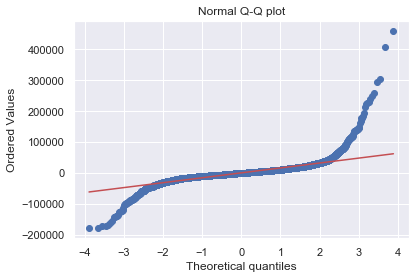

In [209]:
namelist = ['Carat', 'Cut_EX', 'Cut_GO', 'Cut_VG', 'Shape_asscher',
       'Shape_cushion', 'Shape_emerald', 'Shape_heart', 'Shape_marquise',
       'Shape_oval', 'Shape_pear', 'Shape_princess', 'Shape_radiant',
       'Shape_round', 'Fluor_fa', 'Fluor_me', 'Fluor_no', 'Fluor_st',
       'Fluor_ve', 'Clarity_FL', 'Clarity_IF', 'Clarity_SI1', 'Clarity_VS1',
       'Clarity_VS2', 'Clarity_VVS1', 'Clarity_VVS2', 'Color_D', 'Color_E',
       'Color_F', 'Color_G', 'Color_H', 'Color_I', 'Color_J', 'Color_K']
alphavec = 10**np.linspace(-2,2,200)
Lasso_CV_poly(df_nosell_non_numC[namelist],df_nosell_non_numC.Price,0.20,alphavec,2,1)

(34140, 34) (34140, 34)
(34139, 630)


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24833102747.095703, tolerance: 18572974942.376225
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26418163995.125, tolerance: 18572974942.376225
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26751921981.492188, tolerance: 18572974942.376225
  tol, rng, random, positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to inc

Ideal alpha for L1 penalty:  13.667163564620074
R2 :  0.939340596710058
MAE :  10523.766526424273


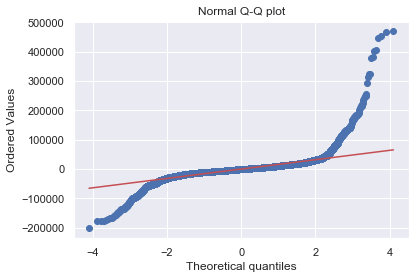

In [133]:
namelist = ['Carat', 'Cut_EX', 'Cut_GO', 'Cut_VG', 'Shape_asscher',
       'Shape_cushion', 'Shape_emerald', 'Shape_heart', 'Shape_marquise',
       'Shape_oval', 'Shape_pear', 'Shape_princess', 'Shape_radiant',
       'Shape_round', 'Fluor_fa', 'Fluor_me', 'Fluor_no', 'Fluor_st',
       'Fluor_ve', 'Clarity_FL', 'Clarity_IF', 'Clarity_SI1', 'Clarity_VS1',
       'Clarity_VS2', 'Clarity_VVS1', 'Clarity_VVS2', 'Color_D', 'Color_E',
       'Color_F', 'Color_G', 'Color_H', 'Color_I', 'Color_J', 'Color_K']
alphavec = 10**np.linspace(-2,2,200)
Lasso_CV_poly(df_nosell_non_numC[namelist],df_nosell_non_numC.Price,0.50,alphavec,2,1)

NORMAL TEST

In [185]:
def normal(X,y):
    #calculates the least squared solution via the normal equations
    # beta = (X^T*X)^(-1)*X^T*y
    print(X.shape)
    A = np.linalg.inv(np.matmul(X.transpose(),X))
    print(A.shape)
    inter_med_vector = np.matmul(X.transpose(),y)
    beta = np.matmul(A,inter_med_vector)
    return beta

In [202]:
namelist = ['ColorNum', 'ClarityNum', 'Carat'] 
p =  PolynomialFeatures(degree=2)
X = p.fit_transform(df_num[namelist])
beta = normal(X,df_num.Price.as_matrix())
print(beta)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


(68279, 630)


LinAlgError: Singular matrix

In [201]:
p =  PolynomialFeatures(degree=2)
X = p.fit_transform(df_num[namelist])

%timeit beta = normal(X,df_num.Price.as_matrix())

KeyError: "['Shape_cushion', 'Clarity_FL', 'Color_F', 'Clarity_VVS2', 'Shape_pear', 'Color_G', 'Fluor_ve', 'Shape_heart', 'Clarity_IF', 'Shape_emerald', 'Shape_princess', 'Color_E', 'Clarity_VS2', 'Cut_VG', 'Color_I', 'Color_H', 'Cut_EX', 'Clarity_VVS1', 'Color_J', 'Shape_marquise', 'Cut_GO', 'Color_K', 'Shape_asscher', 'Fluor_fa', 'Fluor_st', 'Shape_oval', 'Shape_radiant', 'Shape_round', 'Clarity_VS1', 'Fluor_no', 'Fluor_me', 'Color_D', 'Clarity_SI1'] not in index"

In [200]:

%timeit test_train_split(df_nosell_non_numC[namelist],df_nosell_non_numC.Price,0.20,degree_=2,verbose=0,scaled=1)

Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
Poly Training R2 = 0.9421245247771084,Poly Testing R2 = 0.9411907062629712
6.07 s ± 70.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [207]:
namelist = ['ColorNum', 'ClarityNum', 'Carat'] 
p =  PolynomialFeatures(degree=2)
X = p.fit_transform(df_num[namelist])
%timeit test_train_split(X,df_num.Price,testsize=0.99)

7.32 ms ± 967 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
